### Experiment Description

#### Objective:
The objective of this experiment is to evaluate whether **KAN (Kolmogorov-Arnold Network)**, due to its increased complexity, can maintain or improve performance compared to **Standard** networks, even when the number of hidden layers is reduced. Since KAN networks are more flexible and powerful, we expect that they can achieve or exceed the performance of standard networks, even in reduced configurations.

#### Models' Architecture:
All models use variants of the fully connected **LeNet-300** network, with the following configurations:

- **LeNet300_OutputOnly**: Network with only the output layer (784 -> 10).
- **LeNet300_HiddenLayerOnly**: Network with a single hidden layer (784 -> 300 -> 10).
- **LeNet300_Full**: Network with two hidden layers (784 -> 300 -> 100 -> 10).

These configurations allow us to compare the performance of **KAN** and **Standard** networks when reducing the number of hidden layers.

#### Dataset:
The dataset used is **MNIST**, which contains grayscale images of handwritten digits (28x28 pixels), classified into 10 categories (digits from 0 to 9). The images are flattened into vectors of size 784 to be passed into the fully connected models.

#### Common Parameters:
All models are trained with the following common parameters:
- **Batch size**: 16
- **Optimizer**: Stochastic Gradient Descent (SGD)
- **Learning Rate**: 0.01
- **Momentum**: Absent (set to 0)
- **Loss Function**: CrossEntropyLoss
- **Dataset**: MNIST
- **Learning Rate Scheduling Strategy**: Exponential decay (EXP decay) with **gamma = 0.96**

> The **exponential decay scheduling** gradually reduces the learning rate according to the formula:
> \[
> lr_{t+1} = lr_t \times \gamma
> \]
> Where **gamma = 0.96**.

#### Differences Between Configurations:
The two main configurations compared are:

1. **Standard Configuration (Standard LeNet-300)**:
   - **Architecture**: Traditional LeNet-300 network without regularization.
   
2. **KAN Configuration (Kolmogorov-Arnold Network)**:
   - **Architecture**: Kolmogorov-Arnold Network using 3rd-order splines on a grid of 5 points.
   - **Purpose**: KAN networks introduce higher complexity through splines, which should allow them to maintain or improve performance even when hidden layers are reduced.

#### Purpose of the Experiment:
The purpose of this experiment is to determine if **KAN** networks, due to their more complex architecture, can maintain high performance or even improve it, even when hidden units are removed compared to the **Standard** configuration. Specifically, the experiment aims to evaluate:

- **Accuracy** on both training and test sets, comparing versions with or without hidden layers.
- **Loss** during training and testing, to understand how KAN networks converge compared to standard networks.

It is expected that **KAN** networks can achieve better or equivalent performance compared to **Standard** networks, even with reduced architectures, due to their more flexible learning capabilities.

#### Expected Results:
- **Improved performance** in **KAN** models, especially in the reduced versions (e.g., **OutputOnly**), compared to the **Standard** versions.
- **Better generalization** in **KAN** networks, with lower loss and higher accuracy on test sets compared to standard models.
- **Robustness** of **KAN** networks even with fewer hidden layers, due to the higher complexity provided by splines.

#### Graphs:
The results are visualized in two-panel graphs:
1. **Accuracy**: Comparison of training and test accuracy for both model types (Standard and KAN).
2. **Loss**: Comparison of training and test loss for both model types (Standard and KAN).

Each graph shows the evolution of performance across epochs, allowing us to evaluate the convergence and generalization of the models.


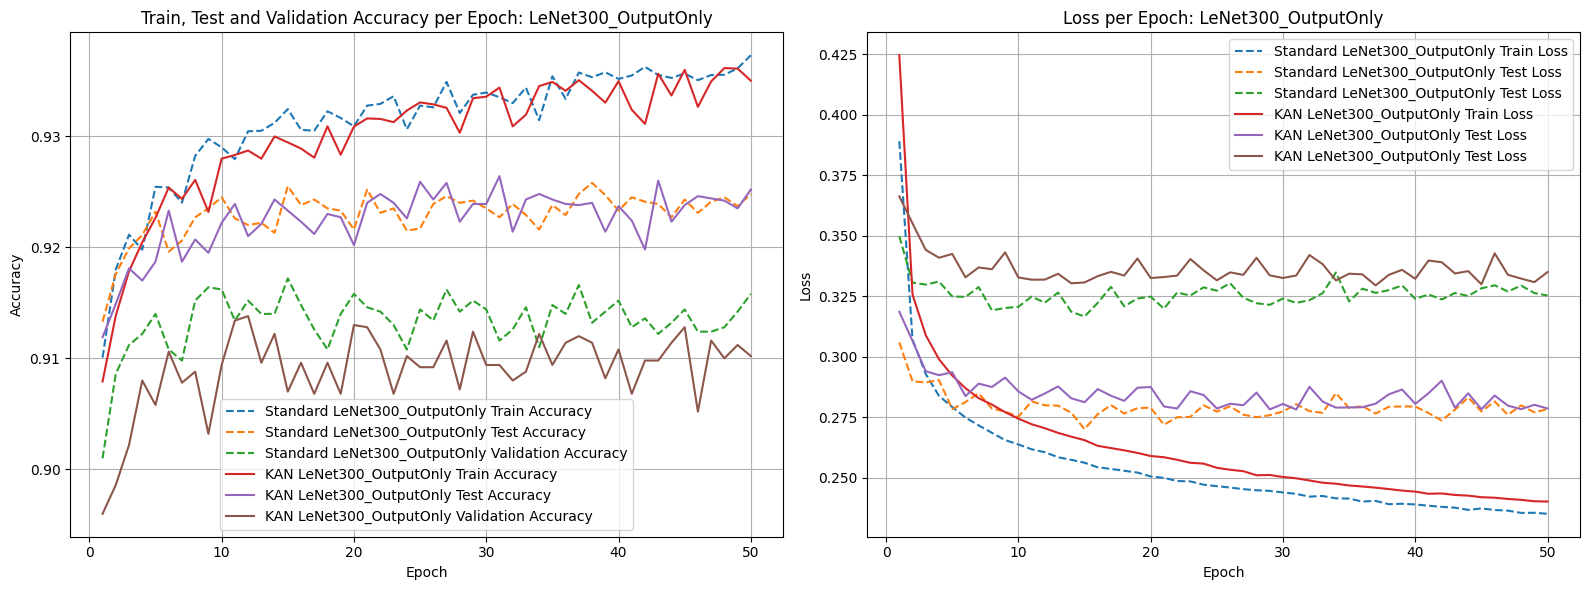

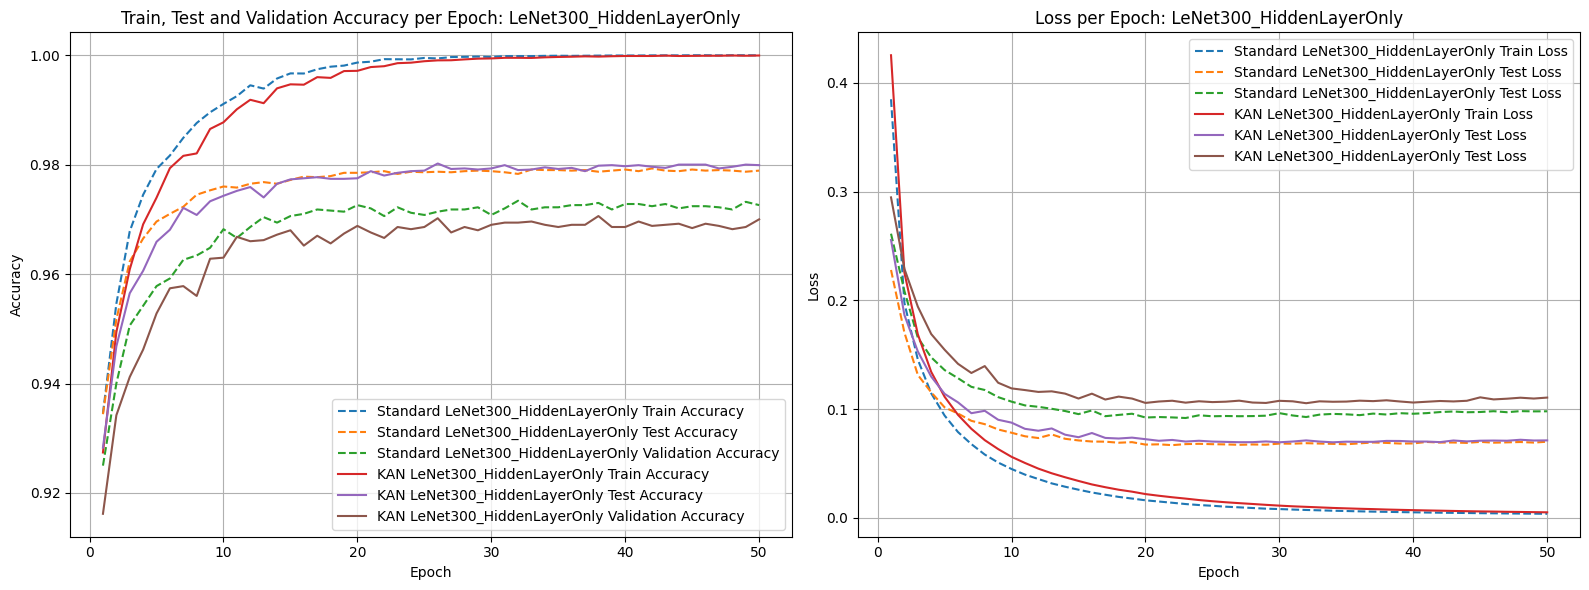

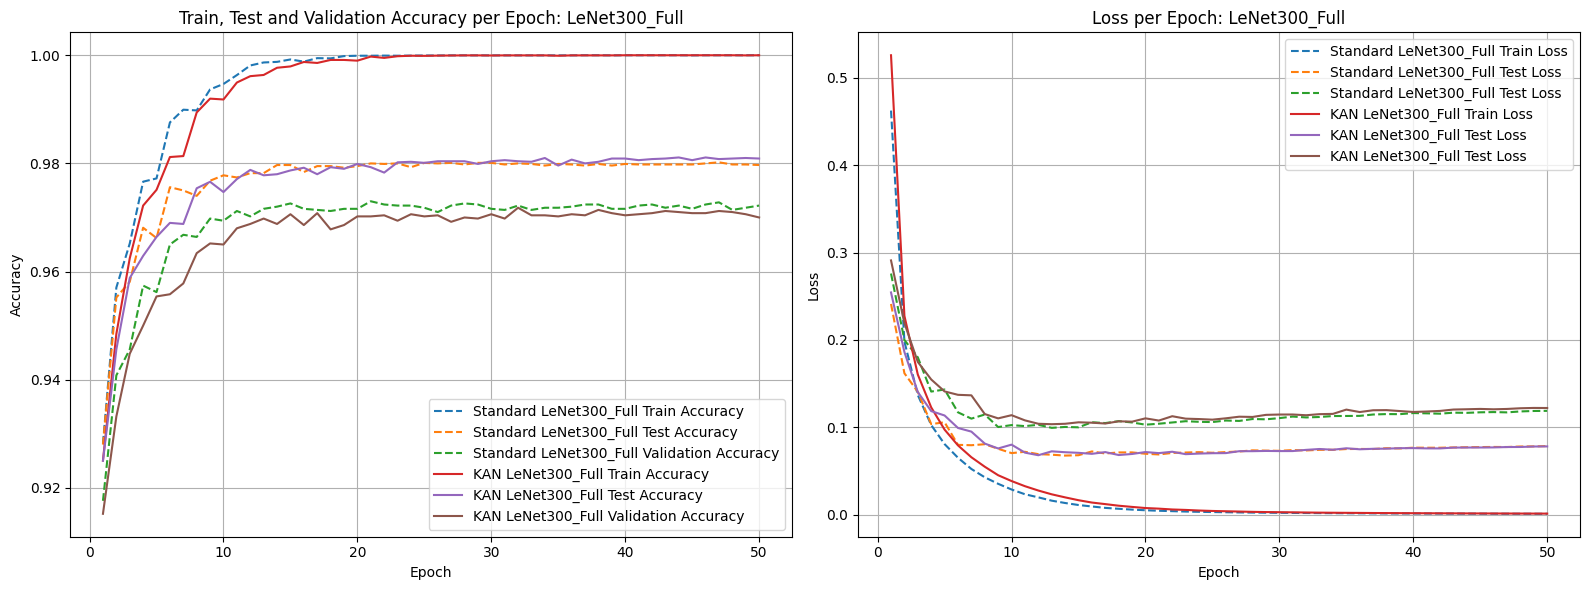

In [20]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Define models and CSV folders to load confusion matrices and losses from
model_types = ['LeNet300_OutputOnly', 'LeNet300_HiddenLayerOnly', 'LeNet300_Full']

# Function to extract epoch number from the file name
def extract_epoch_number(filename):
    match = re.search(r'epoch_(\d+)', filename)
    return int(match.group(1)) if match else -1  # Returns -1 if no epoch is found

# Function to calculate accuracy from confusion matrix
def calculate_accuracy_from_confusion_matrix(conf_matrix):
    total_correct = np.trace(conf_matrix)  # Sum of diagonal elements (correct predictions)
    total_samples = np.sum(conf_matrix)  # Total number of samples (sum of all elements)
    accuracy = total_correct / total_samples
    return accuracy

# Function to load accuracies for both training and test confusion matrices
def load_accuracies_from_csv(folder, phase='test'):
    accuracies = {}
    for model in model_types:
        model_accuracies = []
        csv_folder = os.path.join(folder, model, 'confusion_matrices_not_normalized_csv')
        
        # List all CSV files that match the pattern for test or train
        epoch_files = [f for f in os.listdir(csv_folder) if f.startswith(f'{phase}') and f.endswith('.csv')]
        
        # Sort files based on the extracted epoch number
        epoch_files_sorted = sorted(epoch_files, key=extract_epoch_number)
        
        for epoch_file in epoch_files_sorted:
            epoch_path = os.path.join(csv_folder, epoch_file)
            # Load the confusion matrix, skip the first row, and cast to integers
            conf_matrix = pd.read_csv(epoch_path, header=None).values[1:, :].astype(int)
            accuracy = calculate_accuracy_from_confusion_matrix(conf_matrix)
            model_accuracies.append(accuracy)
        accuracies[model] = model_accuracies
    return accuracies

# Function to load losses from the CSV file
def load_losses_from_csv(folder):
    losses = {}
    for model in model_types:
        loss_file_path = os.path.join(folder, model, 'losses.csv')
        if os.path.exists(loss_file_path):
            loss_data = pd.read_csv(loss_file_path)
            train_losses = loss_data['Train Loss'].tolist()
            test_losses = loss_data['Test Loss'].tolist()
            validation_losses = loss_data['Validation Loss'].tolist()
            losses[model] = {'train': train_losses, 'test': test_losses, 'val': validation_losses}
    return losses

# Define directories
standard_leenet_dir = 'results/results_standard_None_SGD_lr0.01_0_0'
kan_leenet_dir = 'results/results_None_SGD_lr0.01_5_3'

# Load accuracies from both directories for test and train
standard_test_accuracies = load_accuracies_from_csv(standard_leenet_dir, phase='test')
kan_test_accuracies = load_accuracies_from_csv(kan_leenet_dir, phase='test')
standard_train_accuracies = load_accuracies_from_csv(standard_leenet_dir, phase='train')
kan_train_accuracies = load_accuracies_from_csv(kan_leenet_dir, phase='train')
standard_val_accuracies = load_accuracies_from_csv(standard_leenet_dir, phase='val')
kan_val_accuracies = load_accuracies_from_csv(kan_leenet_dir, phase='val')

# Load losses from both directories
standard_losses = load_losses_from_csv(standard_leenet_dir)
kan_losses = load_losses_from_csv(kan_leenet_dir)

# Plot accuracies and losses for comparison
epochs = list(range(1, len(next(iter(standard_test_accuracies.values()))) + 1))

# Separate plots for each model type (3 models)
for model in model_types:
    plt.figure(figsize=(16, 6))
    
    # Subplot for accuracies (Train vs Test)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, standard_train_accuracies[model], label=f'Standard {model} Train Accuracy', linestyle='--')
    plt.plot(epochs, standard_test_accuracies[model], label=f'Standard {model} Test Accuracy', linestyle='--')
    plt.plot(epochs, standard_val_accuracies[model], label=f'Standard {model} Validation Accuracy', linestyle='--')
    plt.plot(epochs, kan_train_accuracies[model], label=f'KAN {model} Train Accuracy', linestyle='-')
    plt.plot(epochs, kan_test_accuracies[model], label=f'KAN {model} Test Accuracy', linestyle='-')
    plt.plot(epochs, kan_val_accuracies[model], label=f'KAN {model} Validation Accuracy', linestyle='-')
    plt.title(f'Train, Test and Validation Accuracy per Epoch: {model}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Subplot for losses
    if model in standard_losses and model in kan_losses:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, standard_losses[model]['train'], label=f'Standard {model} Train Loss', linestyle='--')
        plt.plot(epochs, standard_losses[model]['test'], label=f'Standard {model} Test Loss', linestyle='--')
        plt.plot(epochs, standard_losses[model]['val'], label=f'Standard {model} Test Loss', linestyle='--')
        plt.plot(epochs, kan_losses[model]['train'], label=f'KAN {model} Train Loss', linestyle='-')
        plt.plot(epochs, kan_losses[model]['test'], label=f'KAN {model} Test Loss', linestyle='-')
        plt.plot(epochs, kan_losses[model]['val'], label=f'KAN {model} Test Loss', linestyle='-')
        plt.title(f'Loss per Epoch: {model}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


### Experiment Description

#### Objective:
The objective of this experiment is to compare the performance of **standard fully connected neural networks** and **Kolmogorov-Arnold Networks (KAN)** with different configurations. Specifically, the experiment investigates whether increasing the number of interpolation points and the spline order of KAN layers enhances the model’s ability to generalize and achieve better accuracy on the MNIST dataset.

#### Models' Architecture:
The following three models are tested:
- **LeNet300_OutputOnly**: Network with only the output layer (784 -> 10).
- **LeNet300_HiddenLayerOnly**: Network with one hidden layer (784 -> 300 -> 10).
- **LeNet300_Full**: Network with two hidden layers (784 -> 300 -> 100 -> 10).

Each model is tested with **Standard Fully Connected Layers** and **KAN Layers**, with KAN layers varying in spline order and the number of interpolation points.

#### Dataset:
The dataset used is the **MNIST** dataset, consisting of grayscale images (28x28) of handwritten digits, where the task is to classify the images into 10 categories (digits 0–9).

#### Common Training Parameters:
All models are trained with:
- **Batch Size**: 16
- **Optimizer**: **Stochastic Gradient Descent (SGD)** with no momentum (momentum = 0).
- **Learning Rate**: 0.01
- **Learning Rate Scheduling Strategy**: Exponential decay (EXP decay) with **gamma = 0.96**
- **Loss Function**: CrossEntropyLoss
- **Dataset**: MNIST

#### Configurations for KAN:
The experiment uses different configurations of KAN layers, varying the spline order and the number of interpolation points. The configurations are as follows:

- `results/results_none_SGD_lr0.01_5_3`: 
  - **Spline Order**: 3
  - **Number of Interpolation Points**: 5

- `results/results_none_SGD_lr0.01_10_4`: 
  - **Spline Order**: 4
  - **Number of Interpolation Points**: 10

- `results/results_none_SGD_lr0.01_50_10`: 
  - **Spline Order**: 10
  - **Number of Interpolation Points**: 50

- `results/results_none_SGD_lr0.01_100_10`: 
  - **Spline Order**: 10
  - **Number of Interpolation Points**: 100

#### Purpose of the Experiment:
This experiment aims to assess whether increasing the complexity of KAN layers by adding more interpolation points and using higher spline orders leads to better performance compared to standard fully connected networks, even when reducing hidden layers in the KAN models.

The hypothesis is that more complex KAN layers should provide better generalization on the test set compared to simpler architectures.

#### Results Visualization:
The results are visualized as:
- **Accuracy** plots: Training and test accuracy over epochs.
- **Loss** plots: Training and test loss over epochs.

These results will help to determine the effect of increasing KAN layer complexity on performance.


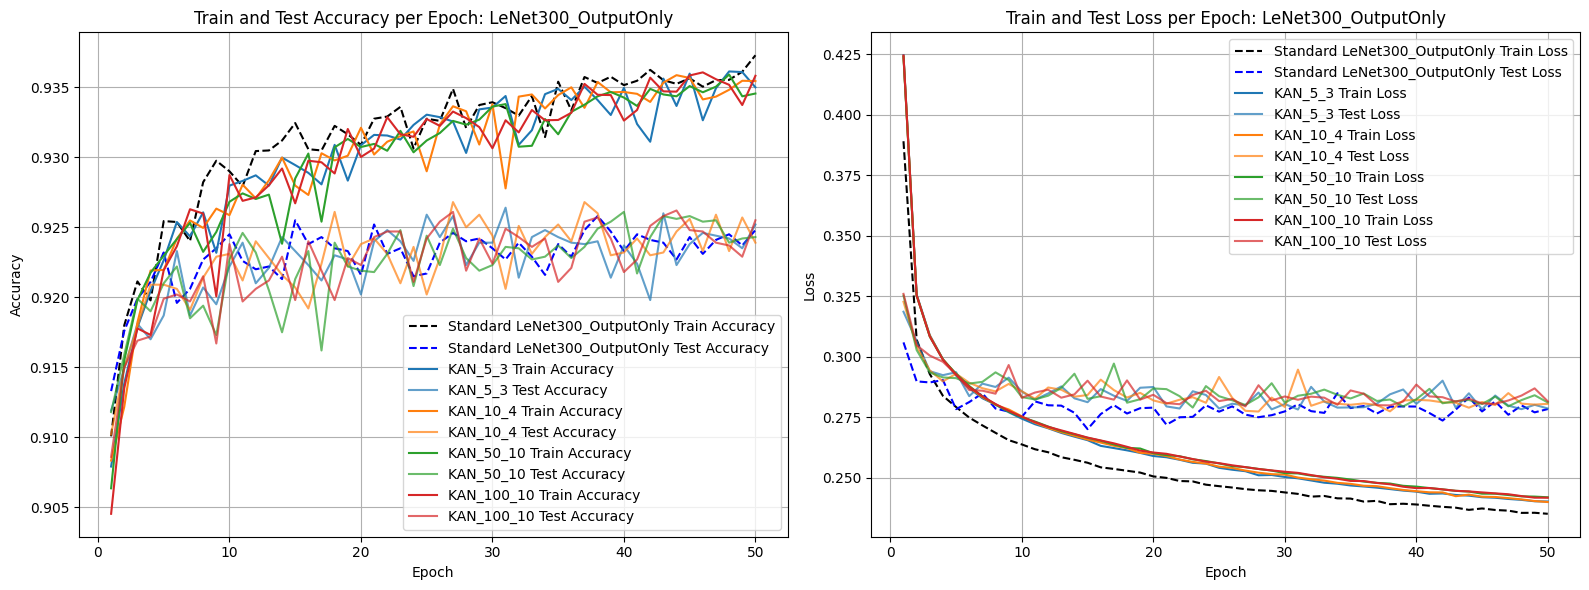

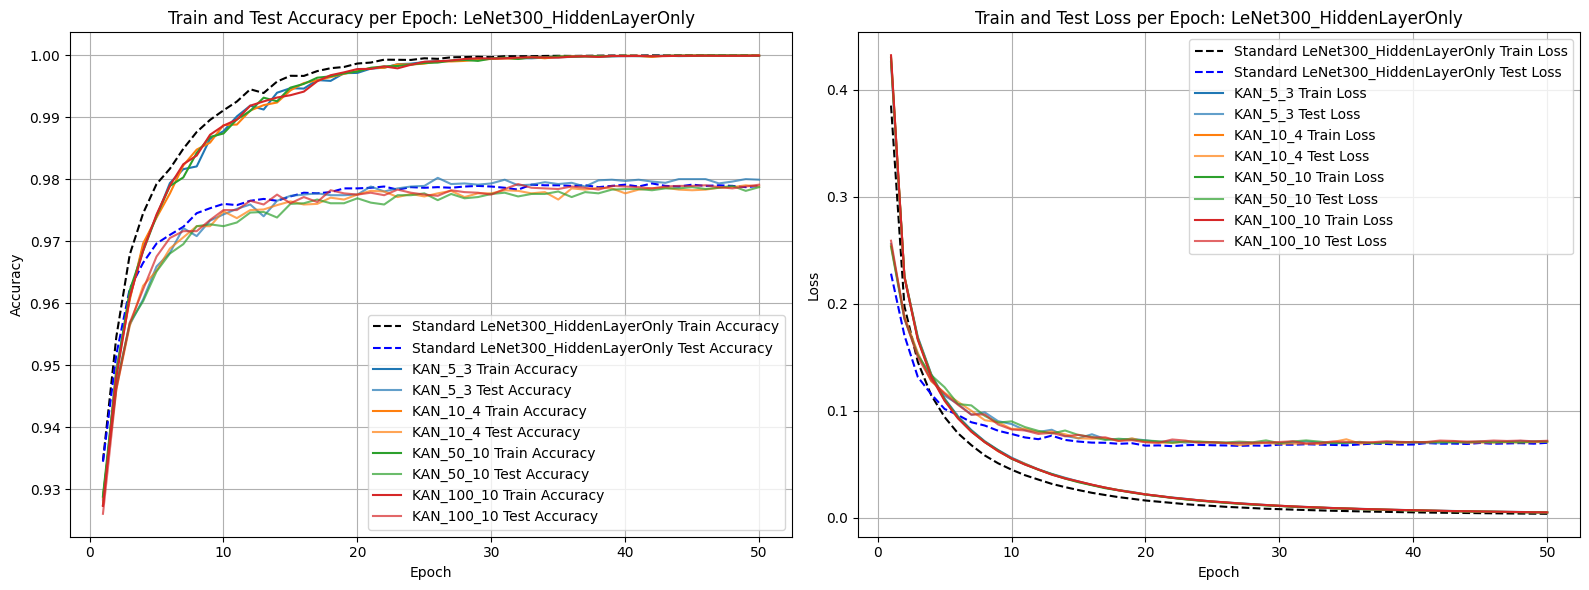

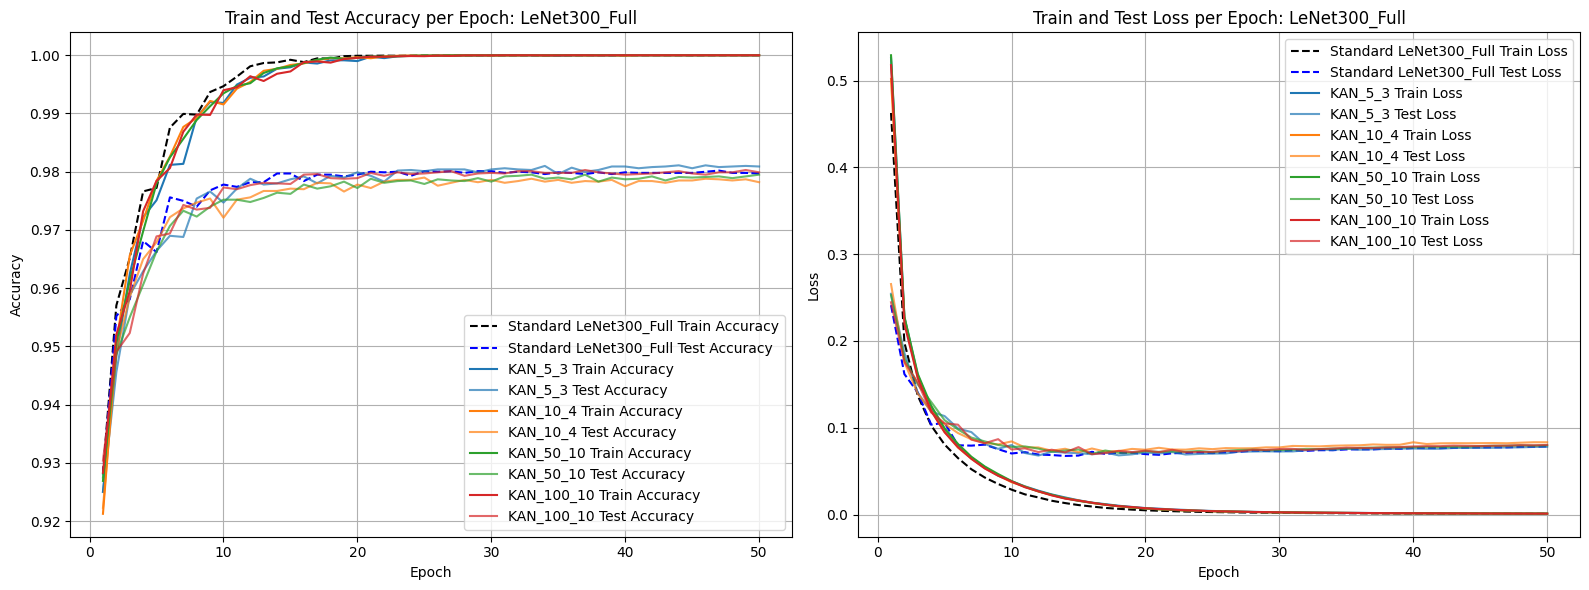

In [18]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Define models and CSV folders to load confusion matrices and losses from
model_types = ['LeNet300_OutputOnly', 'LeNet300_HiddenLayerOnly', 'LeNet300_Full']

# Function to extract epoch number from the file name
def extract_epoch_number(filename):
    match = re.search(r'epoch_(\d+)', filename)
    return int(match.group(1)) if match else -1  # Returns -1 if no epoch is found

# Function to calculate accuracy from confusion matrix
def calculate_accuracy_from_confusion_matrix(conf_matrix):
    total_correct = np.trace(conf_matrix)  # Sum of diagonal elements (correct predictions)
    total_samples = np.sum(conf_matrix)  # Total number of samples (sum of all elements)
    accuracy = total_correct / total_samples
    return accuracy

# Function to load accuracies for both training and test confusion matrices
def load_accuracies_from_csv(folder, phase='test'):
    accuracies = {}
    for model in model_types:
        model_accuracies = []
        csv_folder = os.path.join(folder, model, 'confusion_matrices_not_normalized_csv')
        
        # List all CSV files that match the pattern for test or train
        epoch_files = [f for f in os.listdir(csv_folder) if f.startswith(f'{phase}') and f.endswith('.csv')]
        
        # Sort files based on the extracted epoch number
        epoch_files_sorted = sorted(epoch_files, key=extract_epoch_number)
        
        for epoch_file in epoch_files_sorted:
            epoch_path = os.path.join(csv_folder, epoch_file)
            # Load the confusion matrix, skip the first row, and cast to integers
            conf_matrix = pd.read_csv(epoch_path, header=None).values[1:, :].astype(int)
            accuracy = calculate_accuracy_from_confusion_matrix(conf_matrix)
            model_accuracies.append(accuracy)
        accuracies[model] = model_accuracies
    return accuracies

# Function to load losses from the CSV file
def load_losses_from_csv(folder):
    losses = {}
    for model in model_types:
        loss_file_path = os.path.join(folder, model, 'losses.csv')
        if os.path.exists(loss_file_path):
            loss_data = pd.read_csv(loss_file_path)
            train_losses = loss_data['Train Loss'].tolist()
            test_losses = loss_data['Test Loss'].tolist()
            losses[model] = {'train': train_losses, 'test': test_losses}
    return losses

# Define directories for standard LeNet and multiple KAN configurations
standard_leenet_dir = 'results/results_standard_None_SGD_lr0.01_0_0'
kan_dirs = [
    'results/results_None_SGD_lr0.01_5_3',
    'results/results_None_SGD_lr0.01_10_4',
    'results/results_None_SGD_lr0.01_50_10',
    'results/results_None_SGD_lr0.01_100_10'
]

kan_labels = ['KAN_5_3', 'KAN_10_4', 'KAN_50_10', 'KAN_100_10']

# Load accuracies and losses for standard and KAN models
standard_test_accuracies = load_accuracies_from_csv(standard_leenet_dir, phase='test')
standard_train_accuracies = load_accuracies_from_csv(standard_leenet_dir, phase='train')
standard_losses = load_losses_from_csv(standard_leenet_dir)

kan_test_accuracies = [load_accuracies_from_csv(kan_dir, phase='test') for kan_dir in kan_dirs]
kan_train_accuracies = [load_accuracies_from_csv(kan_dir, phase='train') for kan_dir in kan_dirs]
kan_losses = [load_losses_from_csv(kan_dir) for kan_dir in kan_dirs]

# Plot side-by-side figures for training and test accuracies, and training and test losses
epochs = list(range(1, len(next(iter(standard_test_accuracies.values()))) + 1))

# Plot for accuracies and losses side by side
for model in model_types:
    plt.figure(figsize=(16, 6))
    
    # Subplot for accuracies (Train vs Test)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, standard_train_accuracies[model], label=f'Standard {model} Train Accuracy', linestyle='--', color='black')
    plt.plot(epochs, standard_test_accuracies[model], label=f'Standard {model} Test Accuracy', linestyle='--', color='blue')

    for idx, label in enumerate(kan_labels):
        plt.plot(epochs, kan_train_accuracies[idx][model], label=f'{label} Train Accuracy', linestyle='-', color=f'C{idx}')
        plt.plot(epochs, kan_test_accuracies[idx][model], label=f'{label} Test Accuracy', linestyle='-', color=f'C{idx}', alpha=0.7)

    plt.title(f'Train and Test Accuracy per Epoch: {model}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Subplot for losses (Train vs Test)
    plt.subplot(1, 2, 2)
    if model in standard_losses:
        plt.plot(epochs, standard_losses[model]['train'], label=f'Standard {model} Train Loss', linestyle='--', color='black')
        plt.plot(epochs, standard_losses[model]['test'], label=f'Standard {model} Test Loss', linestyle='--', color='blue')

    for idx, label in enumerate(kan_labels):
        if model in kan_losses[idx]:
            plt.plot(epochs, kan_losses[idx][model]['train'], label=f'{label} Train Loss', linestyle='-', color=f'C{idx}')
            plt.plot(epochs, kan_losses[idx][model]['test'], label=f'{label} Test Loss', linestyle='-', color=f'C{idx}', alpha=0.7)

    plt.title(f'Train and Test Loss per Epoch: {model}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


In [22]:
import os
import pandas as pd
import numpy as np
import re

# Define models and CSV folders to load confusion matrices and losses from
model_types = ['LeNet300_OutputOnly', 'LeNet300_HiddenLayerOnly', 'LeNet300_Full']

# Define standard and multiple KAN directories with labels
standard_leenet_dir = 'results/results_standard_None_SGD_lr0.01_0_0'
kan_dirs = [
    'results/results_None_SGD_lr0.01_5_3',
    'results/results_None_SGD_lr0.01_10_4',
    'results/results_None_SGD_lr0.01_50_10',
    'results/results_None_SGD_lr0.01_100_10'
]
kan_labels = ['KAN_5_3', 'KAN_10_4', 'KAN_50_10', 'KAN_100_10']

# Function to extract epoch number from the file name
def extract_epoch_number(filename):
    match = re.search(r'epoch_(\d+)', filename)
    return int(match.group(1)) if match else -1

# Function to calculate accuracy and precision from confusion matrix
def calculate_metrics_from_confusion_matrix(conf_matrix):
    total_correct = np.trace(conf_matrix)
    total_samples = np.sum(conf_matrix)
    accuracy = total_correct / total_samples
    true_positives = np.diag(conf_matrix)
    precision_per_class = true_positives / np.sum(conf_matrix, axis=0)
    precision = np.nanmean(precision_per_class)
    return accuracy, precision

# Function to load accuracies and precision for both training and test confusion matrices
def load_accuracies_and_precision_from_csv(folder, phase='test'):
    metrics = {}
    for model in model_types:
        model_metrics = {'accuracy': [], 'precision': []}
        csv_folder = os.path.join(folder, model, 'confusion_matrices_not_normalized_csv')
        epoch_files = [f for f in os.listdir(csv_folder) if f.startswith(f'{phase}') and f.endswith('.csv')]
        epoch_files_sorted = sorted(epoch_files, key=extract_epoch_number)
        for epoch_file in epoch_files_sorted:
            epoch_path = os.path.join(csv_folder, epoch_file)
            conf_matrix = pd.read_csv(epoch_path, header=None).values[1:, :].astype(int)
            accuracy, precision = calculate_metrics_from_confusion_matrix(conf_matrix)
            model_metrics['accuracy'].append(accuracy)
            model_metrics['precision'].append(precision)
        metrics[model] = model_metrics
    return metrics

# Function to load losses from CSV files
def load_losses_from_csv(folder):
    losses = {}
    for model in model_types:
        loss_file_path = os.path.join(folder, model, 'losses.csv')
        if os.path.exists(loss_file_path):
            loss_data = pd.read_csv(loss_file_path)
            train_losses = loss_data['Train Loss'].tolist()
            test_losses = loss_data['Test Loss'].tolist()
            validation_losses = loss_data['Validation Loss'].tolist()
            total_losses = [(t + te + v) / 3 for t, te, v in zip(train_losses, test_losses, validation_losses)]
            losses[model] = {
                'train': train_losses,
                'test': test_losses,
                'val': validation_losses,
                'total': total_losses
            }
    return losses

# Include 50 epochs
epochs = list(range(1, 51))

# Function to generate tables for each KAN configuration
def generate_tables(standard_leenet_dir, kan_dirs, kan_labels):
    # Load data for standard directory
    standard_metrics = load_accuracies_and_precision_from_csv(standard_leenet_dir, phase='test')
    standard_losses = load_losses_from_csv(standard_leenet_dir)
    
    # Load data for each KAN configuration
    for kan_dir, kan_label in zip(kan_dirs, kan_labels):
        kan_metrics = load_accuracies_and_precision_from_csv(kan_dir, phase='test')
        kan_losses = load_losses_from_csv(kan_dir)
        
        # Collect data for each model type
        for model in model_types:
            accuracy_precision_data = []
            loss_data = []
            for epoch in epochs:
                accuracy_precision_data.append({
                    'Model': model,
                    'Epoch': epoch,
                    'Standard Test Accuracy': standard_metrics[model]['accuracy'][epoch - 1] if epoch - 1 < len(standard_metrics[model]['accuracy']) else np.nan,
                    'Standard Test Precision': standard_metrics[model]['precision'][epoch - 1] if epoch - 1 < len(standard_metrics[model]['precision']) else np.nan,
                    f'{kan_label} Test Accuracy': kan_metrics[model]['accuracy'][epoch - 1] if epoch - 1 < len(kan_metrics[model]['accuracy']) else np.nan,
                    f'{kan_label} Test Precision': kan_metrics[model]['precision'][epoch - 1] if epoch - 1 < len(kan_metrics[model]['precision']) else np.nan
                })
                loss_data.append({
                    'Model': model,
                    'Epoch': epoch,
                    'Standard Train Loss': standard_losses[model]['train'][epoch - 1] if epoch - 1 < len(standard_losses[model]['train']) else np.nan,
                    'Standard Test Loss': standard_losses[model]['test'][epoch - 1] if epoch - 1 < len(standard_losses[model]['test']) else np.nan,
                    'Standard Val Loss': standard_losses[model]['val'][epoch - 1] if epoch - 1 < len(standard_losses[model]['val']) else np.nan,
                    'Standard Total Loss': standard_losses[model]['total'][epoch - 1] if epoch - 1 < len(standard_losses[model]['total']) else np.nan,
                    f'{kan_label} Train Loss': kan_losses[model]['train'][epoch - 1] if epoch - 1 < len(kan_losses[model]['train']) else np.nan,
                    f'{kan_label} Test Loss': kan_losses[model]['test'][epoch - 1] if epoch - 1 < len(kan_losses[model]['test']) else np.nan,
                    f'{kan_label} Val Loss': kan_losses[model]['val'][epoch - 1] if epoch - 1 < len(kan_losses[model]['val']) else np.nan,
                    f'{kan_label} Total Loss': kan_losses[model]['total'][epoch - 1] if epoch - 1 < len(kan_losses[model]['total']) else np.nan
                })
            
            # Convert lists to DataFrames and reset index to remove the unnecessary index column
            accuracy_precision_df = pd.DataFrame(accuracy_precision_data).reset_index(drop=True)
            loss_df = pd.DataFrame(loss_data).reset_index(drop=True)
            
            # Filter the DataFrames for epochs that are multiples of 5
            accuracy_precision_df_filtered = accuracy_precision_df[accuracy_precision_df['Epoch'] % 5 == 0].reset_index(drop=True)
            loss_df_filtered = loss_df[loss_df['Epoch'] % 5 == 0].reset_index(drop=True)
            
            # Display filtered tables for each model and KAN configuration
            display(f"Accuracy and Precision Data - Model: {model}, Configuration: {kan_label}")
            display(accuracy_precision_df_filtered)
            display(f"Loss Data - Model: {model}, Configuration: {kan_label}")
            display(loss_df_filtered)

# Execute table generation
generate_tables(standard_leenet_dir, kan_dirs, kan_labels)


'Accuracy and Precision Data - Model: LeNet300_OutputOnly, Configuration: KAN_5_3'

,Model,Epoch,Standard Test Accuracy,Standard Test Precision,KAN_5_3 Test Accuracy,KAN_5_3 Test Precision
0,LeNet300_OutputOnly,5,0.9232,0.922491,0.9187,0.918494
1,LeNet300_OutputOnly,10,0.9245,0.924250,0.9222,0.921255
2,LeNet300_OutputOnly,15,0.9255,0.924595,0.9233,0.922403
3,LeNet300_OutputOnly,20,0.9216,0.921523,0.9202,0.920375
4,LeNet300_OutputOnly,25,0.9217,0.921256,0.9259,0.925565
5,LeNet300_OutputOnly,30,0.9235,0.922830,0.9239,0.923281
6,LeNet300_OutputOnly,35,0.9238,0.922912,0.9243,0.923400
7,LeNet300_OutputOnly,40,0.9233,0.922621,0.9237,0.923086
8,LeNet300_OutputOnly,45,0.9243,0.923340,0.9238,0.923137
9,LeNet300_OutputOnly,50,0.9248,0.923772,0.9252,0.924585


'Loss Data - Model: LeNet300_OutputOnly, Configuration: KAN_5_3'

,Model,Epoch,Standard Train Loss,Standard Test Loss,Standard Val Loss,Standard Total Loss,KAN_5_3 Train Loss,KAN_5_3 Test Loss,KAN_5_3 Val Loss,KAN_5_3 Total Loss
0,LeNet300_OutputOnly,5,0.279146,0.278259,0.324838,0.294081,0.292155,0.293531,0.342413,0.309366
1,LeNet300_OutputOnly,10,0.263681,0.275100,0.320576,0.286452,0.274341,0.285571,0.332694,0.297536
2,LeNet300_OutputOnly,15,0.256116,0.269998,0.316546,0.280887,0.265446,0.281144,0.330629,0.292406
3,LeNet300_OutputOnly,20,0.250458,0.278888,0.324760,0.284702,0.258896,0.287416,0.332456,0.292922
4,LeNet300_OutputOnly,25,0.246433,0.277219,0.327224,0.283625,0.254018,0.278539,0.331510,0.288022
5,LeNet300_OutputOnly,30,0.243852,0.277330,0.324002,0.281728,0.250229,0.280409,0.332482,0.287707
6,LeNet300_OutputOnly,35,0.241303,0.278715,0.322808,0.280942,0.246714,0.278984,0.334261,0.286653
7,LeNet300_OutputOnly,40,0.238861,0.279338,0.323842,0.280681,0.244175,0.280450,0.332154,0.285593
8,LeNet300_OutputOnly,45,0.237220,0.277316,0.328216,0.280917,0.241865,0.278231,0.329870,0.283322
9,LeNet300_OutputOnly,50,0.235014,0.278303,0.325216,0.279511,0.240082,0.278547,0.334940,0.284523


'Accuracy and Precision Data - Model: LeNet300_HiddenLayerOnly, Configuration: KAN_5_3'

,Model,Epoch,Standard Test Accuracy,Standard Test Precision,KAN_5_3 Test Accuracy,KAN_5_3 Test Precision
0,LeNet300_HiddenLayerOnly,5,0.9696,0.969458,0.9659,0.965572
1,LeNet300_HiddenLayerOnly,10,0.9760,0.975970,0.9743,0.974398
2,LeNet300_HiddenLayerOnly,15,0.9772,0.977173,0.9773,0.977269
3,LeNet300_HiddenLayerOnly,20,0.9785,0.978474,0.9775,0.977408
4,LeNet300_HiddenLayerOnly,25,0.9786,0.978584,0.9789,0.978906
5,LeNet300_HiddenLayerOnly,30,0.9788,0.978836,0.9793,0.979243
6,LeNet300_HiddenLayerOnly,35,0.9790,0.978936,0.9792,0.979155
7,LeNet300_HiddenLayerOnly,40,0.9791,0.979133,0.9797,0.979638
8,LeNet300_HiddenLayerOnly,45,0.9791,0.979154,0.9800,0.980043
9,LeNet300_HiddenLayerOnly,50,0.9789,0.978945,0.9799,0.979909


'Loss Data - Model: LeNet300_HiddenLayerOnly, Configuration: KAN_5_3'

,Model,Epoch,Standard Train Loss,Standard Test Loss,Standard Val Loss,Standard Total Loss,KAN_5_3 Train Loss,KAN_5_3 Test Loss,KAN_5_3 Val Loss,KAN_5_3 Total Loss
0,LeNet300_HiddenLayerOnly,5,0.094080,0.101625,0.135925,0.110543,0.111365,0.114037,0.154631,0.126678
1,LeNet300_HiddenLayerOnly,10,0.044916,0.078267,0.106872,0.076685,0.056114,0.087554,0.119047,0.087572
2,LeNet300_HiddenLayerOnly,15,0.025867,0.071188,0.095393,0.064149,0.033925,0.074154,0.109736,0.072605
3,LeNet300_HiddenLayerOnly,20,0.016134,0.067369,0.092270,0.058591,0.021855,0.072336,0.105689,0.066627
4,LeNet300_HiddenLayerOnly,25,0.011088,0.067743,0.093417,0.057416,0.015272,0.070142,0.106452,0.063955
5,LeNet300_HiddenLayerOnly,30,0.008063,0.068301,0.096310,0.057558,0.011226,0.069490,0.107626,0.062781
6,LeNet300_HiddenLayerOnly,35,0.006260,0.067661,0.095206,0.056376,0.008705,0.070040,0.106924,0.061890
7,LeNet300_HiddenLayerOnly,40,0.005084,0.068437,0.095742,0.056421,0.007061,0.070178,0.106055,0.061098
8,LeNet300_HiddenLayerOnly,45,0.004286,0.069865,0.097344,0.057165,0.005905,0.070948,0.110825,0.062559
9,LeNet300_HiddenLayerOnly,50,0.003714,0.070020,0.097987,0.057240,0.005073,0.071236,0.110605,0.062305


'Accuracy and Precision Data - Model: LeNet300_Full, Configuration: KAN_5_3'

,Model,Epoch,Standard Test Accuracy,Standard Test Precision,KAN_5_3 Test Accuracy,KAN_5_3 Test Precision
0,LeNet300_Full,5,0.9662,0.966445,0.9664,0.966590
1,LeNet300_Full,10,0.9778,0.977785,0.9747,0.974931
2,LeNet300_Full,15,0.9797,0.979537,0.9787,0.978696
3,LeNet300_Full,20,0.9795,0.979298,0.9799,0.979858
4,LeNet300_Full,25,0.9801,0.980014,0.9801,0.980094
5,LeNet300_Full,30,0.9801,0.979953,0.9804,0.980339
6,LeNet300_Full,35,0.9799,0.979780,0.9796,0.979625
7,LeNet300_Full,40,0.9799,0.979776,0.9809,0.980902
8,LeNet300_Full,45,0.9798,0.979662,0.9806,0.980574
9,LeNet300_Full,50,0.9797,0.979581,0.9809,0.980880


'Loss Data - Model: LeNet300_Full, Configuration: KAN_5_3'

,Model,Epoch,Standard Train Loss,Standard Test Loss,Standard Val Loss,Standard Total Loss,KAN_5_3 Train Loss,KAN_5_3 Test Loss,KAN_5_3 Val Loss,KAN_5_3 Total Loss
0,LeNet300_Full,5,0.080702,0.105702,0.143236,0.109880,0.097290,0.113480,0.141025,0.117265
1,LeNet300_Full,10,0.028726,0.070393,0.102463,0.067194,0.038402,0.080088,0.113831,0.077440
2,LeNet300_Full,15,0.010949,0.067975,0.099934,0.059619,0.016451,0.070718,0.105679,0.064283
3,LeNet300_Full,20,0.004946,0.069651,0.102955,0.059184,0.007490,0.071605,0.110203,0.063100
4,LeNet300_Full,25,0.002898,0.070783,0.105941,0.059874,0.004141,0.070269,0.108704,0.061038
5,LeNet300_Full,30,0.002020,0.073039,0.110460,0.061839,0.002709,0.072720,0.114573,0.063334
6,LeNet300_Full,35,0.001539,0.075048,0.112932,0.063173,0.001985,0.075933,0.120213,0.066044
7,LeNet300_Full,40,0.001249,0.076614,0.116262,0.064708,0.001573,0.076129,0.117520,0.065074
8,LeNet300_Full,45,0.001034,0.077310,0.117119,0.065154,0.001293,0.076826,0.121002,0.066374
9,LeNet300_Full,50,0.000891,0.078450,0.118777,0.066039,0.001105,0.078058,0.122050,0.067071


'Accuracy and Precision Data - Model: LeNet300_OutputOnly, Configuration: KAN_10_4'

,Model,Epoch,Standard Test Accuracy,Standard Test Precision,KAN_10_4 Test Accuracy,KAN_10_4 Test Precision
0,LeNet300_OutputOnly,5,0.9232,0.922491,0.9209,0.921506
1,LeNet300_OutputOnly,10,0.9245,0.924250,0.9231,0.922035
2,LeNet300_OutputOnly,15,0.9255,0.924595,0.9207,0.920446
3,LeNet300_OutputOnly,20,0.9216,0.921523,0.9238,0.922649
4,LeNet300_OutputOnly,25,0.9217,0.921256,0.9202,0.919592
5,LeNet300_OutputOnly,30,0.9235,0.922830,0.9244,0.923904
6,LeNet300_OutputOnly,35,0.9238,0.922912,0.9252,0.924643
7,LeNet300_OutputOnly,40,0.9233,0.922621,0.9232,0.923006
8,LeNet300_OutputOnly,45,0.9243,0.923340,0.9256,0.924631
9,LeNet300_OutputOnly,50,0.9248,0.923772,0.9239,0.923080


'Loss Data - Model: LeNet300_OutputOnly, Configuration: KAN_10_4'

,Model,Epoch,Standard Train Loss,Standard Test Loss,Standard Val Loss,Standard Total Loss,KAN_10_4 Train Loss,KAN_10_4 Test Loss,KAN_10_4 Val Loss,KAN_10_4 Total Loss
0,LeNet300_OutputOnly,5,0.279146,0.278259,0.324838,0.294081,0.292576,0.292895,0.343051,0.309507
1,LeNet300_OutputOnly,10,0.263681,0.275100,0.320576,0.286452,0.275295,0.285651,0.335380,0.298776
2,LeNet300_OutputOnly,15,0.256116,0.269998,0.316546,0.280887,0.265705,0.284109,0.335906,0.295240
3,LeNet300_OutputOnly,20,0.250458,0.278888,0.324760,0.284702,0.259817,0.281874,0.333432,0.291707
4,LeNet300_OutputOnly,25,0.246433,0.277219,0.327224,0.283625,0.254500,0.291556,0.343393,0.296483
5,LeNet300_OutputOnly,30,0.243852,0.277330,0.324002,0.281728,0.251214,0.279171,0.333210,0.287865
6,LeNet300_OutputOnly,35,0.241303,0.278715,0.322808,0.280942,0.247390,0.280071,0.330008,0.285823
7,LeNet300_OutputOnly,40,0.238861,0.279338,0.323842,0.280681,0.244361,0.282131,0.334710,0.287067
8,LeNet300_OutputOnly,45,0.237220,0.277316,0.328216,0.280917,0.242079,0.281211,0.336149,0.286480
9,LeNet300_OutputOnly,50,0.235014,0.278303,0.325216,0.279511,0.239874,0.280467,0.332819,0.284387


'Accuracy and Precision Data - Model: LeNet300_HiddenLayerOnly, Configuration: KAN_10_4'

,Model,Epoch,Standard Test Accuracy,Standard Test Precision,KAN_10_4 Test Accuracy,KAN_10_4 Test Precision
0,LeNet300_HiddenLayerOnly,5,0.9696,0.969458,0.9652,0.965284
1,LeNet300_HiddenLayerOnly,10,0.9760,0.975970,0.9748,0.974689
2,LeNet300_HiddenLayerOnly,15,0.9772,0.977173,0.9764,0.976344
3,LeNet300_HiddenLayerOnly,20,0.9785,0.978474,0.9775,0.977489
4,LeNet300_HiddenLayerOnly,25,0.9786,0.978584,0.9772,0.977192
5,LeNet300_HiddenLayerOnly,30,0.9788,0.978836,0.9777,0.977600
6,LeNet300_HiddenLayerOnly,35,0.9790,0.978936,0.9767,0.976778
7,LeNet300_HiddenLayerOnly,40,0.9791,0.979133,0.9777,0.977739
8,LeNet300_HiddenLayerOnly,45,0.9791,0.979154,0.9782,0.978159
9,LeNet300_HiddenLayerOnly,50,0.9789,0.978945,0.9788,0.978755


'Loss Data - Model: LeNet300_HiddenLayerOnly, Configuration: KAN_10_4'

,Model,Epoch,Standard Train Loss,Standard Test Loss,Standard Val Loss,Standard Total Loss,KAN_10_4 Train Loss,KAN_10_4 Test Loss,KAN_10_4 Val Loss,KAN_10_4 Total Loss
0,LeNet300_HiddenLayerOnly,5,0.094080,0.101625,0.135925,0.110543,0.110207,0.116703,0.151246,0.126052
1,LeNet300_HiddenLayerOnly,10,0.044916,0.078267,0.106872,0.076685,0.055336,0.082998,0.116739,0.085024
2,LeNet300_HiddenLayerOnly,15,0.025867,0.071188,0.095393,0.064149,0.033565,0.074255,0.107343,0.071721
3,LeNet300_HiddenLayerOnly,20,0.016134,0.067369,0.092270,0.058591,0.021830,0.070938,0.102142,0.064970
4,LeNet300_HiddenLayerOnly,25,0.011088,0.067743,0.093417,0.057416,0.015148,0.070216,0.099904,0.061756
5,LeNet300_HiddenLayerOnly,30,0.008063,0.068301,0.096310,0.057558,0.011223,0.069123,0.101366,0.060571
6,LeNet300_HiddenLayerOnly,35,0.006260,0.067661,0.095206,0.056376,0.008650,0.073309,0.100875,0.060945
7,LeNet300_HiddenLayerOnly,40,0.005084,0.068437,0.095742,0.056421,0.006990,0.071013,0.100908,0.059637
8,LeNet300_HiddenLayerOnly,45,0.004286,0.069865,0.097344,0.057165,0.005833,0.070230,0.101525,0.059196
9,LeNet300_HiddenLayerOnly,50,0.003714,0.070020,0.097987,0.057240,0.005018,0.070964,0.101980,0.059321


'Accuracy and Precision Data - Model: LeNet300_Full, Configuration: KAN_10_4'

,Model,Epoch,Standard Test Accuracy,Standard Test Precision,KAN_10_4 Test Accuracy,KAN_10_4 Test Precision
0,LeNet300_Full,5,0.9662,0.966445,0.9679,0.967458
1,LeNet300_Full,10,0.9778,0.977785,0.9721,0.972372
2,LeNet300_Full,15,0.9797,0.979537,0.9771,0.977069
3,LeNet300_Full,20,0.9795,0.979298,0.9778,0.977732
4,LeNet300_Full,25,0.9801,0.980014,0.9790,0.978916
5,LeNet300_Full,30,0.9801,0.979953,0.9786,0.978534
6,LeNet300_Full,35,0.9799,0.979780,0.9786,0.978521
7,LeNet300_Full,40,0.9799,0.979776,0.9775,0.977502
8,LeNet300_Full,45,0.9798,0.979662,0.9785,0.978445
9,LeNet300_Full,50,0.9797,0.979581,0.9782,0.978159


'Loss Data - Model: LeNet300_Full, Configuration: KAN_10_4'

,Model,Epoch,Standard Train Loss,Standard Test Loss,Standard Val Loss,Standard Total Loss,KAN_10_4 Train Loss,KAN_10_4 Test Loss,KAN_10_4 Val Loss,KAN_10_4 Total Loss
0,LeNet300_Full,5,0.080702,0.105702,0.143236,0.109880,0.095278,0.104373,0.137586,0.112413
1,LeNet300_Full,10,0.028726,0.070393,0.102463,0.067194,0.037333,0.084292,0.114530,0.078718
2,LeNet300_Full,15,0.010949,0.067975,0.099934,0.059619,0.016173,0.071822,0.104340,0.064112
3,LeNet300_Full,20,0.004946,0.069651,0.102955,0.059184,0.007063,0.074694,0.109158,0.063638
4,LeNet300_Full,25,0.002898,0.070783,0.105941,0.059874,0.003929,0.075387,0.112948,0.064088
5,LeNet300_Full,30,0.002020,0.073039,0.110460,0.061839,0.002531,0.077353,0.114257,0.064713
6,LeNet300_Full,35,0.001539,0.075048,0.112932,0.063173,0.001877,0.079638,0.118438,0.066651
7,LeNet300_Full,40,0.001249,0.076614,0.116262,0.064708,0.001511,0.083301,0.120949,0.068587
8,LeNet300_Full,45,0.001034,0.077310,0.117119,0.065154,0.001243,0.082278,0.121847,0.068456
9,LeNet300_Full,50,0.000891,0.078450,0.118777,0.066039,0.001061,0.083305,0.124482,0.069616


'Accuracy and Precision Data - Model: LeNet300_OutputOnly, Configuration: KAN_50_10'

,Model,Epoch,Standard Test Accuracy,Standard Test Precision,KAN_50_10 Test Accuracy,KAN_50_10 Test Precision
0,LeNet300_OutputOnly,5,0.9232,0.922491,0.9210,0.919830
1,LeNet300_OutputOnly,10,0.9245,0.924250,0.9227,0.922027
2,LeNet300_OutputOnly,15,0.9255,0.924595,0.9213,0.920808
3,LeNet300_OutputOnly,20,0.9216,0.921523,0.9219,0.921745
4,LeNet300_OutputOnly,25,0.9217,0.921256,0.9244,0.923703
5,LeNet300_OutputOnly,30,0.9235,0.922830,0.9223,0.921440
6,LeNet300_OutputOnly,35,0.9238,0.922912,0.9237,0.923214
7,LeNet300_OutputOnly,40,0.9233,0.922621,0.9261,0.925428
8,LeNet300_OutputOnly,45,0.9243,0.923340,0.9258,0.924982
9,LeNet300_OutputOnly,50,0.9248,0.923772,0.9243,0.923776


'Loss Data - Model: LeNet300_OutputOnly, Configuration: KAN_50_10'

,Model,Epoch,Standard Train Loss,Standard Test Loss,Standard Val Loss,Standard Total Loss,KAN_50_10 Train Loss,KAN_50_10 Test Loss,KAN_50_10 Val Loss,KAN_50_10 Total Loss
0,LeNet300_OutputOnly,5,0.279146,0.278259,0.324838,0.294081,0.292915,0.291080,0.338899,0.307631
1,LeNet300_OutputOnly,10,0.263681,0.275100,0.320576,0.286452,0.274964,0.283262,0.336329,0.298185
2,LeNet300_OutputOnly,15,0.256116,0.269998,0.316546,0.280887,0.266401,0.282530,0.333993,0.294308
3,LeNet300_OutputOnly,20,0.250458,0.278888,0.324760,0.284702,0.260057,0.286822,0.334298,0.293726
4,LeNet300_OutputOnly,25,0.246433,0.277219,0.327224,0.283625,0.255834,0.283614,0.337151,0.292200
5,LeNet300_OutputOnly,30,0.243852,0.277330,0.324002,0.281728,0.251837,0.280943,0.335906,0.289562
6,LeNet300_OutputOnly,35,0.241303,0.278715,0.322808,0.280942,0.249162,0.282678,0.340677,0.290839
7,LeNet300_OutputOnly,40,0.238861,0.279338,0.323842,0.280681,0.246250,0.282318,0.339149,0.289239
8,LeNet300_OutputOnly,45,0.237220,0.277316,0.328216,0.280917,0.243332,0.280366,0.335245,0.286314
9,LeNet300_OutputOnly,50,0.235014,0.278303,0.325216,0.279511,0.241837,0.281038,0.335912,0.286262


'Accuracy and Precision Data - Model: LeNet300_HiddenLayerOnly, Configuration: KAN_50_10'

,Model,Epoch,Standard Test Accuracy,Standard Test Precision,KAN_50_10 Test Accuracy,KAN_50_10 Test Precision
0,LeNet300_HiddenLayerOnly,5,0.9696,0.969458,0.9651,0.965294
1,LeNet300_HiddenLayerOnly,10,0.9760,0.975970,0.9724,0.972456
2,LeNet300_HiddenLayerOnly,15,0.9772,0.977173,0.9760,0.975934
3,LeNet300_HiddenLayerOnly,20,0.9785,0.978474,0.9769,0.976930
4,LeNet300_HiddenLayerOnly,25,0.9786,0.978584,0.9777,0.977632
5,LeNet300_HiddenLayerOnly,30,0.9788,0.978836,0.9776,0.977521
6,LeNet300_HiddenLayerOnly,35,0.9790,0.978936,0.9780,0.977878
7,LeNet300_HiddenLayerOnly,40,0.9791,0.979133,0.9784,0.978329
8,LeNet300_HiddenLayerOnly,45,0.9791,0.979154,0.9787,0.978613
9,LeNet300_HiddenLayerOnly,50,0.9789,0.978945,0.9787,0.978650


'Loss Data - Model: LeNet300_HiddenLayerOnly, Configuration: KAN_50_10'

,Model,Epoch,Standard Train Loss,Standard Test Loss,Standard Val Loss,Standard Total Loss,KAN_50_10 Train Loss,KAN_50_10 Test Loss,KAN_50_10 Val Loss,KAN_50_10 Total Loss
0,LeNet300_HiddenLayerOnly,5,0.094080,0.101625,0.135925,0.110543,0.110303,0.121929,0.153381,0.128538
1,LeNet300_HiddenLayerOnly,10,0.044916,0.078267,0.106872,0.076685,0.055153,0.090071,0.116044,0.087089
2,LeNet300_HiddenLayerOnly,15,0.025867,0.071188,0.095393,0.064149,0.033214,0.077283,0.106982,0.072493
3,LeNet300_HiddenLayerOnly,20,0.016134,0.067369,0.092270,0.058591,0.021627,0.072189,0.101473,0.065096
4,LeNet300_HiddenLayerOnly,25,0.011088,0.067743,0.093417,0.057416,0.014918,0.070667,0.100246,0.061944
5,LeNet300_HiddenLayerOnly,30,0.008063,0.068301,0.096310,0.057558,0.010970,0.069741,0.103357,0.061356
6,LeNet300_HiddenLayerOnly,35,0.006260,0.067661,0.095206,0.056376,0.008482,0.069933,0.101408,0.059941
7,LeNet300_HiddenLayerOnly,40,0.005084,0.068437,0.095742,0.056421,0.006803,0.070534,0.102841,0.060059
8,LeNet300_HiddenLayerOnly,45,0.004286,0.069865,0.097344,0.057165,0.005706,0.071112,0.104830,0.060549
9,LeNet300_HiddenLayerOnly,50,0.003714,0.070020,0.097987,0.057240,0.004880,0.071193,0.106776,0.060950


'Accuracy and Precision Data - Model: LeNet300_Full, Configuration: KAN_50_10'

,Model,Epoch,Standard Test Accuracy,Standard Test Precision,KAN_50_10 Test Accuracy,KAN_50_10 Test Precision
0,LeNet300_Full,5,0.9662,0.966445,0.9663,0.965974
1,LeNet300_Full,10,0.9778,0.977785,0.9752,0.975162
2,LeNet300_Full,15,0.9797,0.979537,0.9762,0.976173
3,LeNet300_Full,20,0.9795,0.979298,0.9772,0.977286
4,LeNet300_Full,25,0.9801,0.980014,0.9779,0.977735
5,LeNet300_Full,30,0.9801,0.979953,0.9783,0.978247
6,LeNet300_Full,35,0.9799,0.979780,0.9790,0.978941
7,LeNet300_Full,40,0.9799,0.979776,0.9787,0.978708
8,LeNet300_Full,45,0.9798,0.979662,0.9790,0.978940
9,LeNet300_Full,50,0.9797,0.979581,0.9795,0.979484


'Loss Data - Model: LeNet300_Full, Configuration: KAN_50_10'

,Model,Epoch,Standard Train Loss,Standard Test Loss,Standard Val Loss,Standard Total Loss,KAN_50_10 Train Loss,KAN_50_10 Test Loss,KAN_50_10 Val Loss,KAN_50_10 Total Loss
0,LeNet300_Full,5,0.080702,0.105702,0.143236,0.109880,0.099515,0.108729,0.146184,0.118143
1,LeNet300_Full,10,0.028726,0.070393,0.102463,0.067194,0.038648,0.077904,0.111069,0.075873
2,LeNet300_Full,15,0.010949,0.067975,0.099934,0.059619,0.015821,0.074972,0.111452,0.067415
3,LeNet300_Full,20,0.004946,0.069651,0.102955,0.059184,0.007008,0.072952,0.111674,0.063878
4,LeNet300_Full,25,0.002898,0.070783,0.105941,0.059874,0.003862,0.071832,0.112842,0.062845
5,LeNet300_Full,30,0.002020,0.073039,0.110460,0.061839,0.002554,0.074395,0.117589,0.064846
6,LeNet300_Full,35,0.001539,0.075048,0.112932,0.063173,0.001916,0.075920,0.119350,0.065729
7,LeNet300_Full,40,0.001249,0.076614,0.116262,0.064708,0.001526,0.077563,0.121445,0.066845
8,LeNet300_Full,45,0.001034,0.077310,0.117119,0.065154,0.001264,0.078840,0.123072,0.067725
9,LeNet300_Full,50,0.000891,0.078450,0.118777,0.066039,0.001092,0.079811,0.124209,0.068370


'Accuracy and Precision Data - Model: LeNet300_OutputOnly, Configuration: KAN_100_10'

,Model,Epoch,Standard Test Accuracy,Standard Test Precision,KAN_100_10 Test Accuracy,KAN_100_10 Test Precision
0,LeNet300_OutputOnly,5,0.9232,0.922491,0.9199,0.920311
1,LeNet300_OutputOnly,10,0.9245,0.924250,0.9238,0.923047
2,LeNet300_OutputOnly,15,0.9255,0.924595,0.9198,0.920030
3,LeNet300_OutputOnly,20,0.9216,0.921523,0.9223,0.921217
4,LeNet300_OutputOnly,25,0.9217,0.921256,0.9242,0.923328
5,LeNet300_OutputOnly,30,0.9235,0.922830,0.9224,0.922125
6,LeNet300_OutputOnly,35,0.9238,0.922912,0.9211,0.920207
7,LeNet300_OutputOnly,40,0.9233,0.922621,0.9218,0.921819
8,LeNet300_OutputOnly,45,0.9243,0.923340,0.9248,0.924152
9,LeNet300_OutputOnly,50,0.9248,0.923772,0.9255,0.924901


'Loss Data - Model: LeNet300_OutputOnly, Configuration: KAN_100_10'

,Model,Epoch,Standard Train Loss,Standard Test Loss,Standard Val Loss,Standard Total Loss,KAN_100_10 Train Loss,KAN_100_10 Test Loss,KAN_100_10 Val Loss,KAN_100_10 Total Loss
0,LeNet300_OutputOnly,5,0.279146,0.278259,0.324838,0.294081,0.292574,0.292599,0.338490,0.307888
1,LeNet300_OutputOnly,10,0.263681,0.275100,0.320576,0.286452,0.275107,0.282940,0.335395,0.297814
2,LeNet300_OutputOnly,15,0.256116,0.269998,0.316546,0.280887,0.266512,0.290028,0.345088,0.300543
3,LeNet300_OutputOnly,20,0.250458,0.278888,0.324760,0.284702,0.260343,0.284202,0.336054,0.293533
4,LeNet300_OutputOnly,25,0.246433,0.277219,0.327224,0.283625,0.255934,0.281599,0.334958,0.290830
5,LeNet300_OutputOnly,30,0.243852,0.277330,0.324002,0.281728,0.252394,0.283510,0.341184,0.292363
6,LeNet300_OutputOnly,35,0.241303,0.278715,0.322808,0.280942,0.248607,0.286002,0.338044,0.290885
7,LeNet300_OutputOnly,40,0.238861,0.279338,0.323842,0.280681,0.245616,0.288430,0.345027,0.293024
8,LeNet300_OutputOnly,45,0.237220,0.277316,0.328216,0.280917,0.243850,0.280629,0.333901,0.286127
9,LeNet300_OutputOnly,50,0.235014,0.278303,0.325216,0.279511,0.241666,0.281493,0.333697,0.285619


'Accuracy and Precision Data - Model: LeNet300_HiddenLayerOnly, Configuration: KAN_100_10'

,Model,Epoch,Standard Test Accuracy,Standard Test Precision,KAN_100_10 Test Accuracy,KAN_100_10 Test Precision
0,LeNet300_HiddenLayerOnly,5,0.9696,0.969458,0.9675,0.967410
1,LeNet300_HiddenLayerOnly,10,0.9760,0.975970,0.9750,0.974980
2,LeNet300_HiddenLayerOnly,15,0.9772,0.977173,0.9761,0.976116
3,LeNet300_HiddenLayerOnly,20,0.9785,0.978474,0.9775,0.977443
4,LeNet300_HiddenLayerOnly,25,0.9786,0.978584,0.9775,0.977535
5,LeNet300_HiddenLayerOnly,30,0.9788,0.978836,0.9775,0.977461
6,LeNet300_HiddenLayerOnly,35,0.9790,0.978936,0.9784,0.978336
7,LeNet300_HiddenLayerOnly,40,0.9791,0.979133,0.9788,0.978743
8,LeNet300_HiddenLayerOnly,45,0.9791,0.979154,0.9789,0.978915
9,LeNet300_HiddenLayerOnly,50,0.9789,0.978945,0.9791,0.979054


'Loss Data - Model: LeNet300_HiddenLayerOnly, Configuration: KAN_100_10'

,Model,Epoch,Standard Train Loss,Standard Test Loss,Standard Val Loss,Standard Total Loss,KAN_100_10 Train Loss,KAN_100_10 Test Loss,KAN_100_10 Val Loss,KAN_100_10 Total Loss
0,LeNet300_HiddenLayerOnly,5,0.094080,0.101625,0.135925,0.110543,0.109268,0.115939,0.148665,0.124624
1,LeNet300_HiddenLayerOnly,10,0.044916,0.078267,0.106872,0.076685,0.055364,0.082477,0.114525,0.084122
2,LeNet300_HiddenLayerOnly,15,0.025867,0.071188,0.095393,0.064149,0.033929,0.077461,0.104363,0.071918
3,LeNet300_HiddenLayerOnly,20,0.016134,0.067369,0.092270,0.058591,0.021815,0.070431,0.097684,0.063310
4,LeNet300_HiddenLayerOnly,25,0.011088,0.067743,0.093417,0.057416,0.015185,0.070630,0.098420,0.061412
5,LeNet300_HiddenLayerOnly,30,0.008063,0.068301,0.096310,0.057558,0.011190,0.070756,0.097838,0.059928
6,LeNet300_HiddenLayerOnly,35,0.006260,0.067661,0.095206,0.056376,0.008677,0.070763,0.100437,0.059959
7,LeNet300_HiddenLayerOnly,40,0.005084,0.068437,0.095742,0.056421,0.007067,0.070525,0.101120,0.059571
8,LeNet300_HiddenLayerOnly,45,0.004286,0.069865,0.097344,0.057165,0.005850,0.071389,0.099331,0.058857
9,LeNet300_HiddenLayerOnly,50,0.003714,0.070020,0.097987,0.057240,0.005032,0.071923,0.101986,0.059647


'Accuracy and Precision Data - Model: LeNet300_Full, Configuration: KAN_100_10'

,Model,Epoch,Standard Test Accuracy,Standard Test Precision,KAN_100_10 Test Accuracy,KAN_100_10 Test Precision
0,LeNet300_Full,5,0.9662,0.966445,0.9689,0.968928
1,LeNet300_Full,10,0.9778,0.977785,0.9773,0.977353
2,LeNet300_Full,15,0.9797,0.979537,0.9779,0.978108
3,LeNet300_Full,20,0.9795,0.979298,0.9789,0.978889
4,LeNet300_Full,25,0.9801,0.980014,0.9797,0.979620
5,LeNet300_Full,30,0.9801,0.979953,0.9798,0.979771
6,LeNet300_Full,35,0.9799,0.979780,0.9798,0.979811
7,LeNet300_Full,40,0.9799,0.979776,0.9795,0.979507
8,LeNet300_Full,45,0.9798,0.979662,0.9797,0.979678
9,LeNet300_Full,50,0.9797,0.979581,0.9799,0.979902


'Loss Data - Model: LeNet300_Full, Configuration: KAN_100_10'

,Model,Epoch,Standard Train Loss,Standard Test Loss,Standard Val Loss,Standard Total Loss,KAN_100_10 Train Loss,KAN_100_10 Test Loss,KAN_100_10 Val Loss,KAN_100_10 Total Loss
0,LeNet300_Full,5,0.080702,0.105702,0.143236,0.109880,0.094807,0.105048,0.145200,0.115018
1,LeNet300_Full,10,0.028726,0.070393,0.102463,0.067194,0.038072,0.074996,0.110559,0.074543
2,LeNet300_Full,15,0.010949,0.067975,0.099934,0.059619,0.016086,0.077730,0.115513,0.069776
3,LeNet300_Full,20,0.004946,0.069651,0.102955,0.059184,0.007289,0.073693,0.107798,0.062927
4,LeNet300_Full,25,0.002898,0.070783,0.105941,0.059874,0.003924,0.072278,0.116513,0.064238
5,LeNet300_Full,30,0.002020,0.073039,0.110460,0.061839,0.002579,0.075473,0.117153,0.065068
6,LeNet300_Full,35,0.001539,0.075048,0.112932,0.063173,0.001905,0.077110,0.120244,0.066420
7,LeNet300_Full,40,0.001249,0.076614,0.116262,0.064708,0.001511,0.078482,0.123428,0.067807
8,LeNet300_Full,45,0.001034,0.077310,0.117119,0.065154,0.001246,0.078924,0.125382,0.068518
9,LeNet300_Full,50,0.000891,0.078450,0.118777,0.066039,0.001069,0.080215,0.126770,0.069351
